# Monte Carlo Simulation of Temperature for Weather Derivative Pricing



In this online tutorial series dedicated to weather derivatives we have estimated the parameters of our modified mean-reverting Ornstein-Uhlenbeck process which defines our Temperature dynamics, and have now implemented different models for our time varying volatility. Now we move on to simulating temperature paths using Monte Carlo simulation method under the physical probability measure.

Once we have completed these simulation functions we can move onto implementing the Monte Carlo method under the risk-neutral pricing methodology for valuation of our temperature options.

## Quick Summary on Weather Derivative Contract Features

<b>Aim</b>: we want to price temperature options.

<b>Underlying</b>: HDD/CDD index over given period.

The underlying over a temperature option is the heating/cooling degree days (HDD/CDD) index based on 'approximation' of average temperature and reference (/base) temperature.

### 1. Temperature Underlying
$\large T_n = \frac{T^{max}+T^{min}}{2}$

### 2. Degree Days
For a day $n \in N$:
- $\large HDD_n = (T_{ref}-T_n)^+$
- $\large CDD_n = (T_n - T_{ref})^+$

### 3. Payoff Functions
Here the buyer of an option with receive an amount:
$\large \xi = f(DD)$

Payoff function $f$ is computed on the cumulative index over a period $P$:
   - heating degree seasons $DD = H_n = HDD^{N} = \sum^N_n HDD_n$
   - cooling degree seasons $DD = C_n = CDD^{N} = \sum^N_n CDD_n$

### 4. Typical Seasons OTC

- CDD season: 15-May to 15-Sep
- HDD season: 15-Dec(Nov) to 15-Mar

### 5. Popular Payoff Functions

#### Call with Cap

$\large \xi = min\{\alpha(DD - K)^+, C\}$

<b>where:</b>
 - payoff rates $\large \alpha$ is commonly US$\$2,500$ or US$\$5,000$
 - while caps $\large C$ is commonly US$\$500,000$ or US$\$1,000,000$
 


In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import interpolate

import matplotlib.pyplot as plt

In [2]:
ler = pd.read_csv('dados_83361_D_1910-12-31_2024-03-27.csv', sep=";" , skiprows=10, decimal= ',')
# Dados de Cuiabá

In [3]:
ler

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MAXIMA, DIARIA(°C)","TEMPERATURA MINIMA, DIARIA(°C)",Unnamed: 4
0,1961-01-01,NaN,30.1,21.9,NaN
1,1961-01-02,0.0,32.4,23.9,NaN
2,1961-01-03,4.1,30.7,23.1,NaN
3,1961-01-04,14.8,30.6,23.3,NaN
4,1961-01-05,1.3,31.1,23.3,NaN
...,...,...,...,...,...
23092,2024-03-23,14.2,29.9,23.9,NaN
23093,2024-03-24,0.0,34.2,24.6,NaN
23094,2024-03-25,6.4,29.9,26.1,NaN
23095,2024-03-26,14.6,31.3,23.9,NaN


In [4]:
max_temp = ler['TEMPERATURA MAXIMA, DIARIA(°C)']
min_temp = ler['TEMPERATURA MINIMA, DIARIA(°C)']


In [5]:
ler.set_index('Data Medicao', inplace=True)


In [6]:
ler

,"PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MAXIMA, DIARIA(°C)","TEMPERATURA MINIMA, DIARIA(°C)",Unnamed: 4
Data Medicao,,,,
1961-01-01,NaN,30.1,21.9,NaN
1961-01-02,0.0,32.4,23.9,NaN
1961-01-03,4.1,30.7,23.1,NaN
1961-01-04,14.8,30.6,23.3,NaN
1961-01-05,1.3,31.1,23.3,NaN
...,...,...,...,...
2024-03-23,14.2,29.9,23.9,NaN
2024-03-24,0.0,34.2,24.6,NaN
2024-03-25,6.4,29.9,26.1,NaN


In [7]:
drop_cols = [3]


In [8]:
ler.drop(ler.columns[drop_cols], axis=1, inplace=True)


In [9]:
ler

,"PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MAXIMA, DIARIA(°C)","TEMPERATURA MINIMA, DIARIA(°C)"
Data Medicao,,,
1961-01-01,NaN,30.1,21.9
1961-01-02,0.0,32.4,23.9
1961-01-03,4.1,30.7,23.1
1961-01-04,14.8,30.6,23.3
1961-01-05,1.3,31.1,23.3
...,...,...,...
2024-03-23,14.2,29.9,23.9
2024-03-24,0.0,34.2,24.6
2024-03-25,6.4,29.9,26.1


In [10]:
ler.rename(columns={'TEMPERATURA MAXIMA, DIARIA(°C)':'Tmax', 'TEMPERATURA MINIMA, DIARIA(°C)':'Tmin'}, inplace=True)


In [11]:
ler

,"PRECIPITACAO TOTAL, DIARIO(mm)",Tmax,Tmin
Data Medicao,,,
1961-01-01,NaN,30.1,21.9
1961-01-02,0.0,32.4,23.9
1961-01-03,4.1,30.7,23.1
1961-01-04,14.8,30.6,23.3
1961-01-05,1.3,31.1,23.3
...,...,...,...
2024-03-23,14.2,29.9,23.9
2024-03-24,0.0,34.2,24.6
2024-03-25,6.4,29.9,26.1


In [12]:
# average of the temperature
def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

ler['T'] = ler.apply(avg_temp,axis=1)
# # drop na values here
ler = ler.dropna()
ler_t = ler['T'].copy(deep=True)
ler_t = ler_t.to_frame()

ler_t.head()

,T
Data Medicao,
1961-01-02,28.15
1961-01-03,26.90
1961-01-04,26.95
1961-01-05,27.20
1961-01-06,27.10


In [13]:
ler

,"PRECIPITACAO TOTAL, DIARIO(mm)",Tmax,Tmin,T
Data Medicao,,,,
1961-01-02,0.0,32.4,23.9,28.15
1961-01-03,4.1,30.7,23.1,26.90
1961-01-04,14.8,30.6,23.3,26.95
1961-01-05,1.3,31.1,23.3,27.20
1961-01-06,1.5,30.3,23.9,27.10
...,...,...,...,...
2024-03-22,17.5,34.1,24.2,29.15
2024-03-23,14.2,29.9,23.9,26.90
2024-03-24,0.0,34.2,24.6,29.40


### Modified mean-reverting Ornstein-Uhlenbeck (OU) process

Our model for our mean-reverting Daily Average Temperature (DAT) is described in the following OU process SDE with estimated parameters.

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

correct for the city of Cuiabá

$\large \bar{T_t} = 26.6 + (6.29e-05)t + 1.82 sin((\frac{2\pi}{365.25})t -1.32)$


First derivative does not need finite difference approximation here because the function is differentiable $\large \bar{T'_t}$

$\large \bar{T'_t} = (3.32e-05) + 5.05 (\frac{2\pi}{365.25}) cos((\frac{2\pi}{365.25})t + 1.27)$

correct for the city of Cuiabá

$\large \bar{T'_t} = 26.6 + (6.29e-05)t + 1.82 sin((\frac{2\pi}{365.25})t -1.32)$


Where the date <b>01-Jan 1961</b> corresponds with the first ordinal number 0.

In [14]:
ler_t=ler_t.reset_index()
ler_t.rename(columns={'Data Medicao':'Date'}, inplace=True)
# SEMPRE CONVERTER PARA DATA DATETIME
ler_t['Date'] = pd.to_datetime(ler_t['Date'])
ler_t.set_index('Date', inplace=True)
#ler_t.drop(ler_t.columns[0], axis=1, inplace=True)


In [15]:
ler_t

,T
Date,
1961-01-02,28.15
1961-01-03,26.90
1961-01-04,26.95
1961-01-05,27.20
1961-01-06,27.10
...,...
2024-03-22,29.15
2024-03-23,26.90
2024-03-24,29.40


<AxesSubplot:xlabel='Date'>

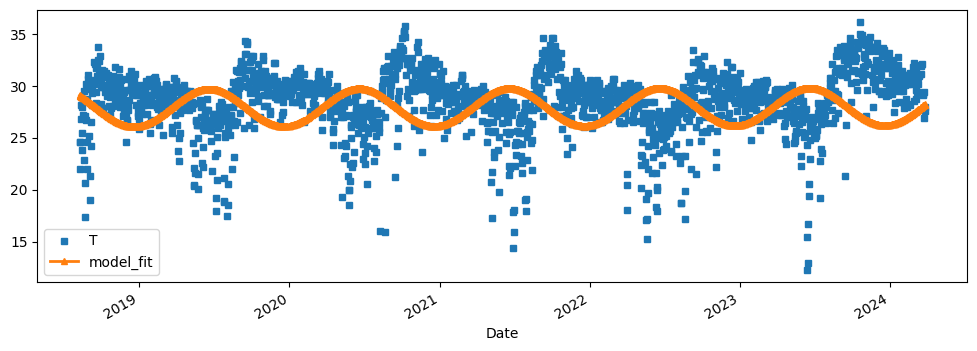

In [16]:
if isinstance(ler_t.index , pd.DatetimeIndex):
    first_ord = ler_t.index.map(dt.datetime.toordinal)[0]
    ler_t.index=ler_t.index.map(dt.datetime.toordinal)

def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T

def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT

Tbar_params = [26.6, 6.29e-05, 1.82,-1.32]
#a 26.6
#  b 6.29e-05
# alpha 1.82
# theta -1.32
    
#ler_t['model_fit'] = T_model(ler_t.index-first_ord, *Tbar_params)
ler_t['model_fit'] = T_model(ler_t.index - first_ord, *Tbar_params)

if not isinstance(ler_t.index , pd.DatetimeIndex):
    ler_t.index=ler_t.index.map(dt.datetime.fromordinal)

ler_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )



2022-08-31 Monte Carlo Simulation of Temperature for Weather Derivative Pricing

<AxesSubplot:xlabel='Date'>

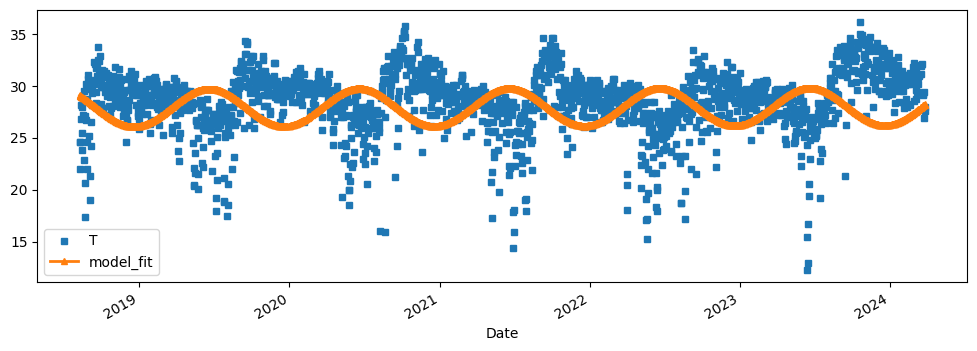

In [17]:
if isinstance(ler_t.index , pd.DatetimeIndex):
    first_ord = ler_t.index.map(dt.datetime.toordinal)[0]
    ler_t.index=ler_t.index.map(dt.datetime.toordinal)

def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T

def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT
# altura, , largura,   
# ADAPTAÇÃO => ADAPTATION
#Tbar_params = [27.8, 2.32e-05, 3.05, 2.57]

#ler_t['model_fit'] = T_model(ler_t.index-first_ord, *Tbar_params)
ler_t['model_fit'] = T_model(ler_t.index - first_ord, *Tbar_params)

if not isinstance(ler_t.index , pd.DatetimeIndex):
    ler_t.index=ler_t.index.map(dt.datetime.fromordinal)

ler_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

### Volatility of Temperature Process

The volatility estimator is based on the the quadratic variation $\Large \sigma_t^2$ of of the temperature process $\Large T_t$

 $\Large \hat{\sigma}^2_t = \frac{1}{N_t} \sum^{N-1}_{i=0} (T_{i+1} - T_i)^2 $

$\Large \sigma_t$ is the dynamic volatility of the Temperature process. This could be both daily (as with our temperature dynamics) or seasonal (for example monthly)

In [18]:
temp_vol = ler['T'].copy(deep=True)


In [19]:
temp_vol

Data Medicao
1961-01-02    28.15
1961-01-03    26.90
1961-01-04    26.95
1961-01-05    27.20
1961-01-06    27.10
              ...  
2024-03-22    29.15
2024-03-23    26.90
2024-03-24    29.40
2024-03-25    28.00
2024-03-26    27.60
Name: T, Length: 21674, dtype: float64

In [20]:
display(temp_vol)


Data Medicao
1961-01-02    28.15
1961-01-03    26.90
1961-01-04    26.95
1961-01-05    27.20
1961-01-06    27.10
              ...  
2024-03-22    29.15
2024-03-23    26.90
2024-03-24    29.40
2024-03-25    28.00
2024-03-26    27.60
Name: T, Length: 21674, dtype: float64

In [21]:
temp_vol=temp_vol.reset_index()
temp_vol.rename(columns={'Data Medicao':'Date'}, inplace=True)
# SEMPRE CONVERTER PARA DATA DATETIME
temp_vol['Date'] = pd.to_datetime(temp_vol['Date'])
temp_vol.set_index('Date', inplace=True)

In [22]:
#temp_vol = temp_vol.to_frame()


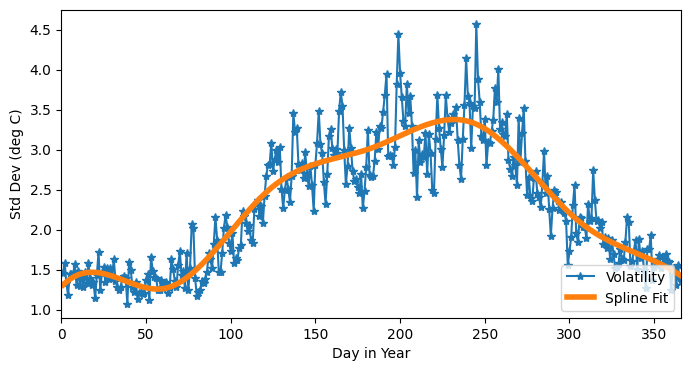

In [23]:
temp_vol['day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

vol = temp_vol.groupby(['day'])['T'].agg(['mean','std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

volatility = spline(5, days, T_std)
plt.figure(figsize=(8,4))
plt.plot(days, T_std, marker='*',label='Volatility')
plt.plot(days, volatility, linewidth=4, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

font:https://www.youtube.com/watch?v=fyNi_7vLMvM

## Simulating Paths
Now with our Euler scheme of approximation:

$\large T_{i+1} = T_{i} + \bar{T'}_{i} + \kappa(\bar{T}_{i} - T_{i}) + \sigma_i z_i$

In [24]:
def euler_step(row, kappa, M):
    """Function for euler scheme approximation step in
    modified OH dynamics for temperature simulations
    Inputs:
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if row['Tbar_shift'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['Tbar_shift']
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    return T_det + T_mrev + sigma

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.438):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temerpature paths
    """
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)

    # Use Modified Ornstein-Uhlenbeck process with estimated parameters to simulate Tbar DAT
    Tbars = T_model(trading_date-first_ord, *Tbar_params)

    # Use derivative of modified OH process SDE to calculate change of Tbar
    dTbars = dT_model(trading_date-first_ord, *Tbar_params)

    # Create DateFrame with thi
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])

    # Create columns for day in year
    mc_temps['day'] = mc_temps.index.dayofyear

    # Apply BSpline volatility model depending on day of year
    mc_temps['vol'] = vol_model[mc_temps['day']-1]

    # Shift Tbar by one day (lagged Tbar series)
    mc_temps['Tbar_shift'] = mc_temps['Tbar'].shift(1)

    # Apply Euler Step Pandas Function
    data = mc_temps.apply(euler_step, args=[kappa, M], axis=1)

    # Create final DataFrame of all simulations
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]],
                 index=trading_dates,columns=range(1,M+1))

    return mc_temps, mc_sims

## Simulation of Temperature

Here we finally simulate temperature under the Physical probability measure $\large \mathbb{P}$

In [25]:
# define trading date range
no_sims = 5
trading_dates = pd.date_range(start='2024-03-27', end='2028-12-31', freq='D')
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)

#### MC_Temps DataFrame
Individual components used to simulate temperature path simulations

In [26]:
mc_temps

,Tbar,dTbar,day,vol,Tbar_shift
2023-12-08,26.259258,-0.005917,342,1.682066,NaN
2023-12-09,26.253606,-0.005387,343,1.673063,26.259258
2023-12-10,26.248484,-0.004856,344,1.664000,26.253606
2023-12-11,26.243894,-0.004323,345,1.654862,26.248484
2023-12-12,26.239838,-0.003789,346,1.645634,26.243894
...,...,...,...,...,...
2027-12-27,26.335330,0.004267,361,1.485995,26.331330
2027-12-28,26.339863,0.004800,362,1.473246,26.335330
2027-12-29,26.344929,0.005331,363,1.460147,26.339863
2027-12-30,26.350526,0.005862,364,1.446683,26.344929


#### MC_Sims DataFrame

Simulated temperature paths for DatetimeIndex for $\large M$ simulated paths.

In [27]:
mc_sims

,1,2,3,4,5
2023-12-08,25.055476,29.695731,28.051649,24.069274,27.499578
2023-12-09,24.421443,22.556914,22.185712,22.113206,27.748941
2023-12-10,26.740864,27.057932,25.605774,25.265745,27.470881
2023-12-11,23.050602,26.649634,27.661385,25.189852,27.578833
2023-12-12,26.803679,25.372202,26.207627,24.247622,27.455988
...,...,...,...,...,...
2027-12-27,25.969921,26.636934,26.665349,23.626093,24.749906
2027-12-28,26.854792,26.660497,23.702523,26.927775,27.113090
2027-12-29,27.441826,26.902866,24.090610,26.741374,23.448960
2027-12-30,21.160352,26.579997,26.415451,25.918390,26.099555


#### Plot an Individual Simulation

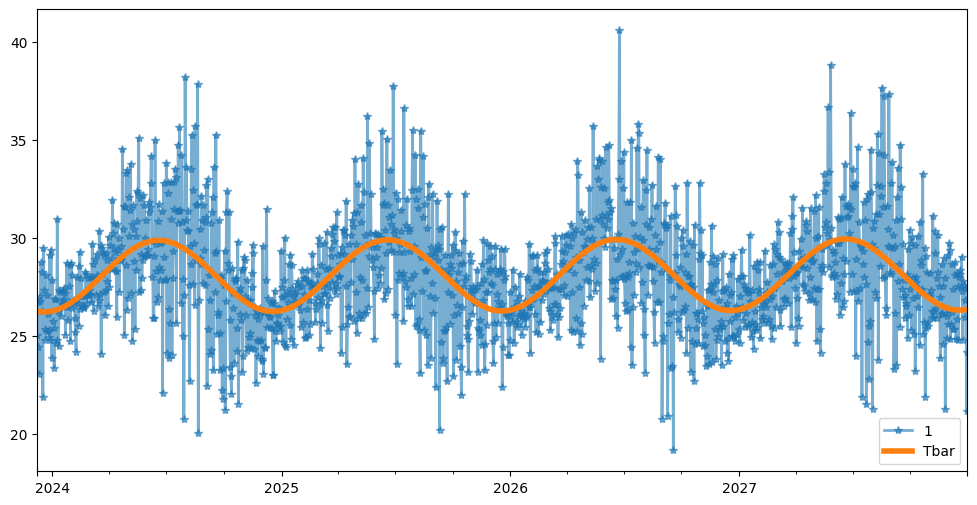

In [28]:
plt.figure(figsize=(12,6))
mc_sims[1].plot(alpha=0.6,linewidth=2, marker='*')
mc_temps["Tbar"].plot(linewidth=4)
plt.legend(loc='lower right')
plt.show()

## Temperature distributions

Let's finally observe the difference between our monte carlo temperature simulations distribution between the peaks of summer and winter days.

Here we simulate 10,000 temperatures on 1st July, 2023 for Winter and 1st Jan, 2023 for a representation of peak Summer temps and volatility.

In [29]:
no_sims = 10000
trading_dates_winter = pd.date_range(start='2025-07-01', end='2025-07-01', freq='D')
mc_temps_winter, mc_sims_winter = monte_carlo_temp(trading_dates_winter, Tbar_params, volatility, first_ord, no_sims)

trading_dates_summer = pd.date_range(start='2025-01-01', end='2025-01-01', freq='D')
mc_temps_summer, mc_sims_summer = monte_carlo_temp(trading_dates_summer, Tbar_params, volatility, first_ord, no_sims)

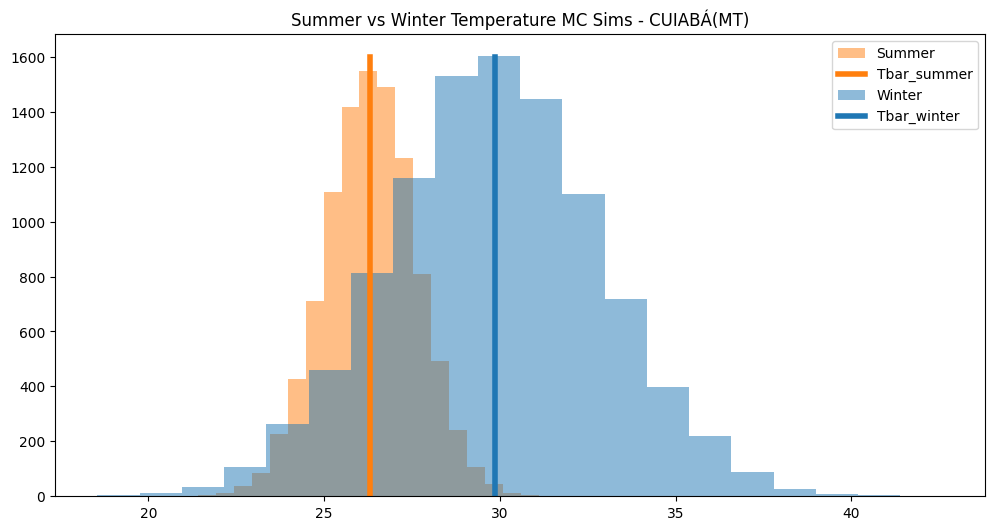

In [30]:
plt.figure(figsize=(12,6))
plt.title('Winter vs Summer Temperature MC Sims')

Tbar_summer = mc_temps_summer.iloc[-1,:]['Tbar']
Tbar_winter = mc_temps_winter.iloc[-1,:]['Tbar']

plt.hist(mc_sims_summer.iloc[-1,:],bins=20, alpha=0.5, label='Summer', color='tab:orange')
plt.plot([Tbar_summer,Tbar_summer],[0,1600], linewidth=4, label='Tbar_summer', color='tab:orange')
plt.title('Summer vs Winter Temperature MC Sims - CUIABÁ(MT)')

plt.hist(mc_sims_winter.iloc[-1,:],bins=20, alpha=0.5, label='Winter', color='tab:blue')
plt.plot([Tbar_winter,Tbar_winter],[0,1600], linewidth=4, label='Tbar_winter', color='tab:blue')
plt.legend()
plt.show()